# Report Similarity v4 
Try 130 reports (fix this with more report samples) 
From tutorial: https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1

In [20]:
import pandas as pd
import re
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = AutoTokenizer.from_pretrained("ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1")
model = AutoModel.from_pretrained('ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1')

Some weights of the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ICLbioengNLP/CXR_BioClinicalBERT_chunkedv1 and are newly initialized: ['bert.poole

In [2]:
report_df = pd.read_csv('117_samples_ready.csv')
display(report_df.head(n=117))

,study_id,diagnosis,diagnosis_id,raw_report
0,52067803,Atelectasis,1,FINAL REPORT ...
1,51065211,Atelectasis,1,FINAL REPORT ...
2,53109065,Atelectasis,1,FINAL REPORT ...
3,56349965,Atelectasis,1,FINAL REPORT ...
4,58788638,Atelectasis,1,FINAL REPORT ...
...,...,...,...,...
112,50771383,No Finding,13,FINAL REPORT ...
113,54205396,No Finding,13,FINAL REPORT ...
114,55697293,No Finding,13,FINAL REPORT ...
115,54577367,No Finding,13,FINAL REPORT ...


In [3]:
data_files = {"test": "117_samples_ready.csv"}
report_dataset = load_dataset("csv", data_files=data_files)

report_dataset

Using custom data configuration default-838b851e9e776c1f
Reusing dataset csv (/media/SharedUsers/dlc19/home/.cache/huggingface/datasets/csv/default-838b851e9e776c1f/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['study_id', 'diagnosis', 'diagnosis_id', 'raw_report'],
        num_rows: 117
    })
})

### Preparing the dataset (130 reports) and the targeted report 

In [24]:
sample_size = len(report_dataset["test"]["study_id"])
sample_dataset = report_dataset["test"][slice(0, sample_size, None)]
print(sample_size)

117


### Prepare the targeted report

In [25]:
# Random targeted reports
Tdata_files = {"test": "13_targeted_reports.csv"}
targeted_dataset = load_dataset("csv", data_files=Tdata_files)

targeted_dataset

Using custom data configuration default-06f97747e584bcce
Reusing dataset csv (/media/SharedUsers/dlc19/home/.cache/huggingface/datasets/csv/default-06f97747e584bcce/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['study_id', 'diagnosis', 'diagnosis_id', 'raw_report'],
        num_rows: 13
    })
})

In [26]:
targeted_report = targeted_dataset["test"][6] 
print(targeted_report)

{'study_id': 57325376, 'diagnosis': 'Lung Lesion', 'diagnosis_id': 7, 'raw_report': '                                 FINAL REPORT EXAMINATION  CHEST AP AND LAT  INDICATION  History F with fever  altered mental status  TECHNIQUE  AP and lateral views of the chest  COMPARISON  Chest radiograph  CT chest   FINDINGS   Cardiac silhouette size is normal  The patient is status post right upper lobectomy  Mediastinal and hilar contours are unchanged with prominence of the left hilum reflective of underlying lymphadenopathy better assessed on the recent CT  Lungs are hyperinflated without focal consolidation  Known nodules within the left upper lobe and left lower lobe are better appreciated on the previous CT  No pleural effusion or pneumothorax is present  There are no acute osseous abnormalities  IMPRESSION   Status post right upper lobectomy  Known nodules within the left upper and lower lobes are better assessed on the recent CT as is the left hilar lymphadenopathy'}


In [27]:
sample_dataset["study_id"].insert(0, targeted_report["study_id"])
sample_dataset["diagnosis"].insert(0, targeted_report["diagnosis"])
sample_dataset["diagnosis_id"].insert(0, targeted_report["diagnosis_id"])
sample_dataset["raw_report"].insert(0, targeted_report["raw_report"])

# print(sample_dataset)
print(len(sample_dataset["study_id"]))
print(len(sample_dataset["diagnosis"]))
print(len(sample_dataset["diagnosis_id"]))
print(len(sample_dataset["raw_report"]))

118
118
118
118


### Mean pooling operation

In [28]:
# initialize dictionary that will contain tokenized sentences
tokens = {'input_ids': [], 'attention_mask': []}

for i in range(sample_size+1):
    report = sample_dataset["raw_report"][i]
    
    # tokenize sentence and append to dictionary lists
    new_tokens = tokenizer.encode_plus(report, max_length=150, truncation=True,
                                       padding='max_length', return_tensors='pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

In [29]:
# reformat list of tensors into single tensor
tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
print(tokens['input_ids'])
print(tokens['attention_mask'])

tensor([[  101,  1509,  2592,  ..., 11806,  1439,   102],
        [  101,  1509,  2592,  ...,     0,     0,     0],
        [  101,  1509,  2592,  ...,     0,     0,     0],
        ...,
        [  101,  1509,  2592,  ...,     0,     0,     0],
        [  101,  1509,  2592,  ...,     0,     0,     0],
        [  101,  1509,  2592,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [30]:
tokens['input_ids'].shape

torch.Size([118, 150])

In [31]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [32]:
embeddings = outputs.last_hidden_state
embeddings.shape

torch.Size([118, 150, 768])

The outputs 'last_hidden_state' tensor contains the dense vector representations of our text:

In [33]:
def mean_pooling(model_output, attention_mask):
    # Access the last_hidden_state
    token_embeddings = model_output.last_hidden_state
    
    # multiply each value in the embedding tensor by its respective attention_mask value so to ignore [PAD] tokens
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [34]:
mean_pooled_embeddings = mean_pooling(outputs, tokens['attention_mask'])
mean_pooled_embeddings

tensor([[ 0.2349, -0.2184,  0.1551,  ...,  0.1679, -0.1031,  0.0034],
        [ 0.2368, -0.0895,  0.1939,  ...,  0.3080,  0.0483,  0.0805],
        [-0.0612, -0.2307,  0.0327,  ...,  0.4765,  0.0502,  0.1212],
        ...,
        [ 0.3066, -0.1377, -0.0080,  ...,  0.2206,  0.0121, -0.0352],
        [ 0.1811, -0.1114,  0.2049,  ...,  0.2766, -0.0548,  0.0574],
        [ 0.1901, -0.1180,  0.0938,  ...,  0.3147, -0.1349,  0.0778]],
       grad_fn=<DivBackward0>)

### Calculating dense similarity vector - cosine similarity

In [35]:
# convert from PyTorch tensor to numpy array
mean_pooled_NPembeddings = mean_pooled_embeddings.detach().numpy()

# calculate
cos_similarities = cosine_similarity(
    [mean_pooled_NPembeddings[0]],
    mean_pooled_NPembeddings[1:]
)

print(cos_similarities)
print(len(cos_similarities[0]))

[[0.9454146  0.92792255 0.89987683 0.946512   0.94648254 0.9442287
  0.9662972  0.9336905  0.93620676 0.92513025 0.9050571  0.9534992
  0.91329116 0.95249367 0.93540686 0.9307746  0.95053923 0.88826764
  0.9532353  0.9148663  0.92872137 0.8996556  0.8878039  0.95198953
  0.9186767  0.90878826 0.88843036 0.94995457 0.9295746  0.9287419
  0.9514549  0.89952695 0.8993743  0.94040364 0.9309712  0.92861676
  0.93524855 0.90142894 0.9006885  0.9246595  0.92472607 0.9290521
  0.9274256  0.8964752  0.9286298  0.9171247  0.937141   0.94048107
  0.88846415 0.9358799  0.93947923 0.9300941  0.92453194 0.9550014
  0.9117544  0.942248   0.95171183 0.92484736 0.9139477  0.9456095
  0.9534458  0.9511833  0.9640048  0.9438749  0.93476856 0.9308376
  0.95438635 0.9536074  0.9358557  0.94916284 0.9403492  0.94466954
  0.9567669  0.9468265  0.9372324  0.87049925 0.8793344  0.91053003
  0.93204653 0.9362133  0.8986268  0.92715925 0.94401795 0.90686256
  0.9056341  0.9176722  0.9197779  0.94549525 0.8547751

In [36]:
# Put all of them into a table:
# remove the targeted report from sample_dataset first
removed_id = sample_dataset["study_id"].pop(0)
removed_report = sample_dataset["raw_report"].pop(0)
removed_diag = sample_dataset["diagnosis"].pop(0)
removed_diag_id = sample_dataset["diagnosis_id"].pop(0)

In [37]:
sample_dataset['cosine_similarity'] = cos_similarities[0].tolist()

print(len(sample_dataset["study_id"]))
print(len(sample_dataset["raw_report"]))
print(len(sample_dataset["cosine_similarity"]))

117
117
117


In [38]:
cos_sim_df = pd.DataFrame.from_dict(sample_dataset)
sort_cos_sim_df = cos_sim_df.sort_values(by=['cosine_similarity'], ascending=False)
print("Top 10 most similar reports with the targeted report of >>", removed_diag, " :")
display(sort_cos_sim_df.head(n=10))

Top 10 most similar reports with the targeted report of >> Lung Lesion  :


,study_id,diagnosis,diagnosis_id,raw_report,cosine_similarity
95,57724025,Pneumonia,11,FINAL REPORT ...,0.977202
115,54577367,No Finding,13,FINAL REPORT ...,0.970582
6,57693229,Atelectasis,1,FINAL REPORT ...,0.966297
62,51334169,Lung Lesion,7,FINAL REPORT ...,0.964005
108,50414267,No Finding,13,FINAL REPORT ...,0.958167
109,53189527,No Finding,13,FINAL REPORT ...,0.957676
72,57861150,Pleural Effusion,9,FINAL REPORT ...,0.956767
53,53891313,Fracture,6,FINAL REPORT ...,0.955001
93,58270659,Pneumonia,11,FINAL REPORT ...,0.954396
66,53268982,Lung Opacity,8,FINAL REPORT ...,0.954386


### Clustering with UMAP 
**Just playing around, not working actually!!!**

In [21]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(mean_pooled_NPembeddings)

In [22]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

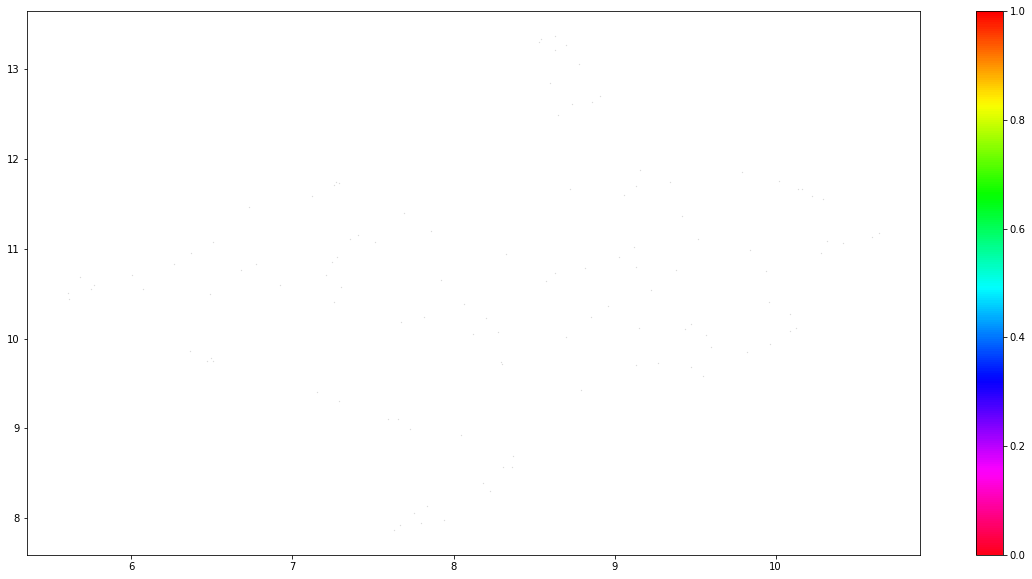

In [23]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(mean_pooled_NPembeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()